In [1]:
from injestion.index.get_embd import fetch_data

c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = fetch_data()

2025-05-06 03:13:22,433 - injestion.index.get_embd - INFO - Retrieved 1 IDs
2025-05-06 03:13:22,433 - injestion.index.get_embd - INFO - Flattened to 79 IDs
2025-05-06 03:13:22,433 - injestion.index.get_embd - INFO - Fetching batch 1 with 50 IDs
2025-05-06 03:13:25,252 - injestion.index.get_embd - INFO - Received 50 vectors in batch
2025-05-06 03:13:25,252 - injestion.index.get_embd - INFO - Fetching batch 2 with 29 IDs
2025-05-06 03:13:26,732 - injestion.index.get_embd - INFO - Received 29 vectors in batch


In [3]:
data

{'data': [{'id': 'faq20',
   'text': "Q: How can I leave a product review?\nA: To leave a product review, navigate to the product page on our website and click on the 'Write a Review' button. You can share your feedback and rating based on your experience with the product.",
   'title': 'faq'},
  {'id': 'faq49',
   'text': 'Q: Can I return a product if it was purchased as a gift?\nA: Yes, you can return a product purchased as a gift. However, refunds will typically be issued to the original payment method used for the purchase.',
   'title': 'faq'},
  {'id': 'faq28',
   'text': "Q: Can I order a product as a gift?\nA: Yes, you can order a product as a gift and have it shipped directly to the recipient. During the checkout process, you can enter the recipient's shipping address.",
   'title': 'faq'},
  {'id': 'faq4',
   'text': 'Q: What is your return policy?\nA: Our return policy allows you to return products within 30 days of purchase for a full refund, provided they are in their orig

In [ ]:
print(len(data['data']))

79


In [1]:
from langchain_openai import OpenAIEmbeddings
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, StateGraph, MessagesState
from typing import List, TypedDict
from langchain_core.documents import Document
from config.config import OPENAI_KEY, PINECONE_API_KEY, GOOGLE_GEMINI_API
from pinecone import Pinecone
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_pinecone import PineconeVectorStore
from langchain_core.messages import HumanMessage, SystemMessage

from helpers.logger import setup_logging, get_logger

pc = Pinecone(api_key=PINECONE_API_KEY)
setup_logging()
logger = get_logger(__name__)

index = pc.Index("assessment")
embeddings = OpenAIEmbeddings(model="text-embedding-3-large", api_key=OPENAI_KEY)
vector_store = PineconeVectorStore(index=index, embedding=embeddings)
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash", api_key=GOOGLE_GEMINI_API)

class State(MessagesState):
    context: List[Document]
    language: str
    sentiment: str
    intent: str

def retrieve(state: State):
    # Use last human message content as query
    if state["intent"] in ["greeting", "goodbye"]: #, "other"
        return {"context": "no content available"}
    last_human_msg = next(
        (m for m in reversed(state["messages"]) if m.type == "human"), None
    )
    query = last_human_msg.content if last_human_msg else ""
    retrieved_docs = vector_store.similarity_search(query, k=4)
    return {"context": retrieved_docs}


def call_model(state: State):
    # docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    if isinstance(state["context"], str):
        docs_content = ""  # No context to use
    else:
        docs_content = "\n\n".join(doc.page_content for doc in state["context"])

    # Get language instruction
    language_instructions = {
        "english": "Respond in English.",
        "hindi": "Respond in Hindi.",
        "tamil": "Respond in Tamil.",
        "telugu": "Respond in Telugu.",
        "malayalam": "Respond in Malayalam.",
        "kannada": "Respond in Kannada.",
        "bengali": "Respond in Bengali.",
        "manglish": "Respond in Malayalam using English letters (Manglish).",
        "hinglish": "Respond in Hindi using English letters (Hinglish).",
        "other": "Respond in the same language as the user's input."
    }
    language_instruction = language_instructions.get(state["language"].lower(), language_instructions["other"])

    # Get sentiment instruction
    sentiment_tones = {
        "happy": "Use a cheerful, friendly, and energetic tone.",
        "neutral": "Use an informative and calm tone.",
        "angry": "Use a polite, empathetic, and calming tone to de-escalate.",
        "sad": "Use a compassionate and reassuring tone.",
        "confused": "Use a clear and patient tone with step-by-step help."
    }
    sentiment_instruction = sentiment_tones.get(state["sentiment"].lower(), "Keep the tone friendly and helpful.")

    system_prompt = (
        f"You are a helpful assistant.\n"
        f"{language_instruction} {sentiment_instruction}\n"
        f"Use the following context to answer:\n{docs_content}")

    if state["intent"] in ["greeting", "goodbye"]: #, "other"
        system_prompt = (
        f"You are a helpful assistant.\n"
        f"{language_instruction} {sentiment_instruction}\n")

    system_message = SystemMessage(content=system_prompt)
    messages = [system_message] + state["messages"]
    logger.info(f"-------------------final prompt is : {messages}-----------------")
    response = llm.invoke(messages)
    return {"messages": [AIMessage(content=response.content)]}


workflow = StateGraph(state_schema=State)
workflow.add_node("retrieve", retrieve)
workflow.add_node("model", call_model)
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "model")

memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


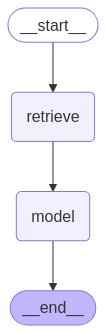

In [2]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass